# Introduction to Decision Trees

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

*With some material from [here](https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084)*

||continuous|categorical|
|---|---|---|
|**supervised**|**regression**|**classification**|
|**unsupervised**|dimension reduction|clustering|

Decision trees come in two flavors: classification and regression. We are only going to talk about classification decision trees. Regression decision trees are similar.

Classification trees are very similar to regression trees. Here is a quick comparison:

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize a different criterion (discussed below)|

## Classification trees
Note that classification trees easily handle **more than two response classes**! (How have other classification models we've seen handled this scenario?)

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.tree import export_graphviz
from IPython.display import SVG
# You may need to install the Python graphviz library. At the command line:
#   pip install graphviz
# You will also need to install the graphviz executables. You can use apt,
# macports, or other installer for your system.
from graphviz import Source

import matplotlib.pyplot as plt

Here's an **example of a classification tree**, which predicts whether or not a patient who had chest pain has heart disease.

Recall the Cleveland heart dataset:
* age: age in years 
* sex: sex (1 = male; 0 = female) 
* cp: chest pain type 
 * -- Value 1: typical angina 
 * -- Value 2: atypical angina 
 * -- Value 3: non-anginal pain 
 * -- Value 4: asymptomatic 
* trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
* chol: serum cholestoral in mg/dl 
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg: resting electrocardiographic results 
 * -- Value 0: normal 
 * -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
 * -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
* thalach: maximum heart rate achieved 
* exang: exercise induced angina (1 = yes; 0 = no) 
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
 * -- Value 1: upsloping 
 * -- Value 2: flat 
 * -- Value 3: downsloping 
* ca: number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
* num: diagnosis of heart disease (angiographic disease status) 
 * -- Value 0: absence.
 * -- Value 1,2,3,4: presence of heart disease


array([0, 2, 1, 3, 4])

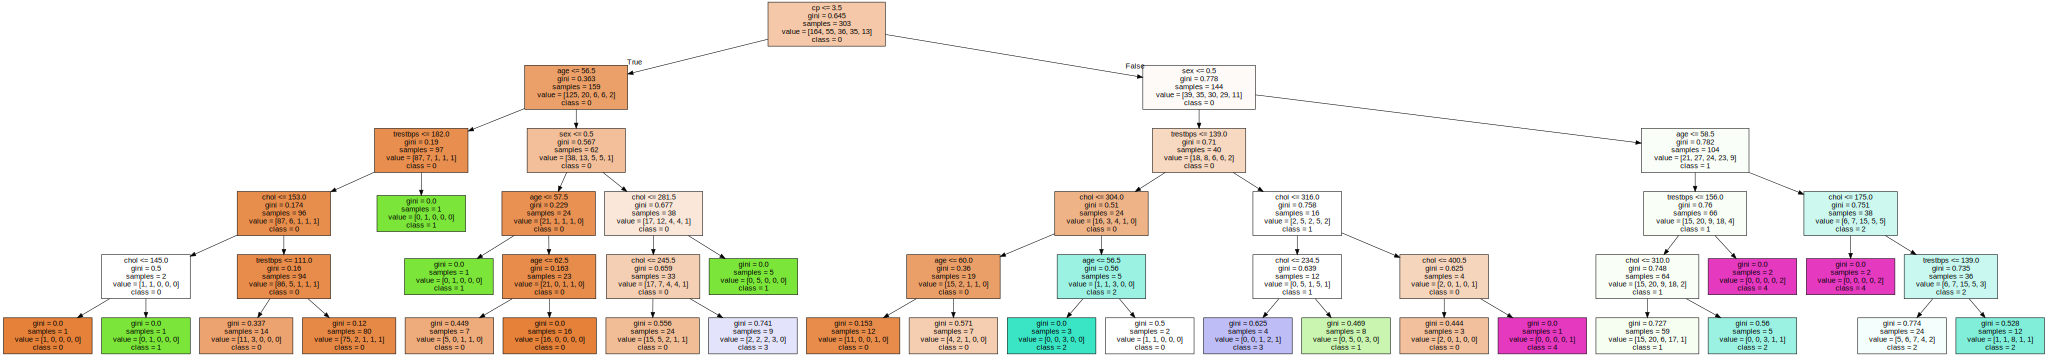

Sample patient 254 to test on. Tree classified as [1]


/home/ben/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


age          43.0
sex           1.0
cp            4.0
trestbps    115.0
chol        303.0
fbs           0.0
restecg       0.0
thalach     181.0
exang         0.0
oldpeak       1.2
slope         2.0
ca            0.0
thal          3.0
disease         0
Name: 254, dtype: object

In [7]:
# Comma-separated values
heart = pd.read_csv('cleveland.csv')

# Rename 'num' column to 'disease'
heart = heart.rename({'num':'disease'}, axis=1)
display(heart.disease.unique())
#heart['disease'] = heart.disease.apply(lambda x: min(x, 1))

# create a list of feature columns
feature_cols = ['age','sex','cp','trestbps','chol']

# define X and y
X = heart[feature_cols]
y = heart.disease

# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X, y)

 # create a Graphviz file
# with open("heart.dot", 'w') as f:
  #   f = export_graphviz(treeclf, out_file=f, feature_names=feature_cols, class_names=['0', '1'], filled = True)

graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
#                                     class_names=['0', '1'], filled = True))
                                    class_names=['0', '1', '2', '3', '4'], filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

# Get a random sample to see how it does
n = heart.shape[0]
# i = random.randint(0, n)
i = 254 # an interesting case
# i = 15 # an interesting case
sample = heart.iloc[i]
print('Sample patient {} to test on. Tree classified as {}'.format(i, treeclf.predict([sample[feature_cols]])))
display(sample)

In the tree plot, each node contains the condition (if/else rule) that splits the data, along with a series of other metrics of the node. Gini refers to the Gini impurity, a measure of the impurity of the node, i.e. how homogeneous are the samples within the node. We say that a node is pure when all its samples belong to the same class (when gini=0). In that case, there is no need for further split and this node is called a leaf. Samples is the number of instances in the node, while the value array shows the distribution of these instances per class. At the bottom we see the majority class of the node. When filled option of export_graphviz is set to True each node gets colored according to the majority class.

While easy to understand, decision trees tend to over-fit the data by constructing complex models. Over fitted models will most likely not generalize well in “unseen” data. Two main approaches to prevent over-fitting are pre and post-pruning. Pre-pruning means restricting the depth of a tree prior to creation while post-pruning is removing non-informative nodes after the tree has been built.

## Splitting criteria for classification trees

Here are common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region
- **cross-entropy:** numerically similar to Gini index, but uses logarithms

Which to use?

- When growing a tree, Gini index and cross-entropy are better measures of "node purity" than classification error rate. The Gini index is faster to compute than cross-entropy, so it is generally preferred (and is used by scikit-learn by default).
- When pruning a tree, classification error rate is preferable in order to maximize predictive accuracy.

Why do some splits result in leaves with the same predicted class (e.g. the first split in the tree above)?

- The split was performed to increase node purity, even though it didn't reduce the classification error.
- Node purity is important because we're interested in the class proportions among the observations in each region.

## Handling categorical predictors

Some implementations of classification trees will allow you to handle categorical predictors **without creating dummy variables**. When splitting on a categorical predictor, they will try splitting on **every possible combination of categories** to find the best split.

**Unfortunately, scikit-learn's classification tree implementation does not support this approach.** Instead, here's how you can handle categorical predictors:

- If a predictor only has **two possible values**, code it as a single binary variable (0 or 1). Since it's treated as a number, splits will naturally occur at 0.5.
- If a predictor has **three or more possible values that are ordered**, code it as a single variable (1, 2, 3, etc). Splits will naturally occur at 1.5, 2.5, etc.
- If a predictor has **three or more possible values that are unordered**, create dummy variables and drop one level as usual. The decision tree won't know that the dummy variables are related to one another, but that shouldn't matter in terms of predictive accuracy.
- If a predictor has **thousands of possible unordered values**, then it may be best to code it as a single variable (1, 2, 3, etc) instead of using dummy variables to minimize the size of the resulting model. ([reference](http://stackoverflow.com/a/18736132/1636598))

We'll see examples of these strategies below.

## Building a classification tree in scikit-learn

We'll build a classification tree using the [Titanic data](https://www.kaggle.com/c/titanic-gettingStarted/data) provided by Kaggle.

In [8]:
# read in the data
titanic = pd.read_csv('titanic.csv')
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [9]:
# look for missing values
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Let's choose our response and a few features, and decide whether we need to adjust them:

- **survived:** This is our response, and is already encoded as 0=died and 1=survived.
- **pclass:** These are the passenger class categories (1=first class, 2=second class, 3=third class). They are ordered, so we'll leave them as-is.
- **sex:** This is a binary category, so we should encode as 0=female and 1=male.
- **age:** We need to fill in the missing values.
- **embarked:** This is the port they emarked from. There are three unordered categories, so we'll create dummy variables.

In [10]:
# encode sex feature
titanic['sex'] = titanic.sex.map({'female':0, 'male':1})

# we could fill in missing values for age, but this is actually bad. could just drop it.
titanic.age.fillna(titanic.age.mean(), inplace=True)

# print the updated DataFrame
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C


In [11]:
# create three dummy variables using get_dummies
pd.get_dummies(titanic.embarked, prefix='embarked').head(10)

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [12]:
# create three dummy variables, drop the first dummy variable, and store this as a DataFrame
embarked_dummies = pd.get_dummies(titanic.embarked, prefix='embarked').iloc[:, 1:]

# concatenate the two dummy variable columns onto the original DataFrame
# note: axis=0 means rows, axis=1 means columns
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,embarked_Q,embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0,1
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0,1
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0,1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0,0


In [13]:
# create a list of feature columns
feature_cols = ['pclass', 'sex', 'age', 'embarked_Q', 'embarked_S']

# define X and y
X = titanic[feature_cols]
y = titanic.survived

In [14]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=1)

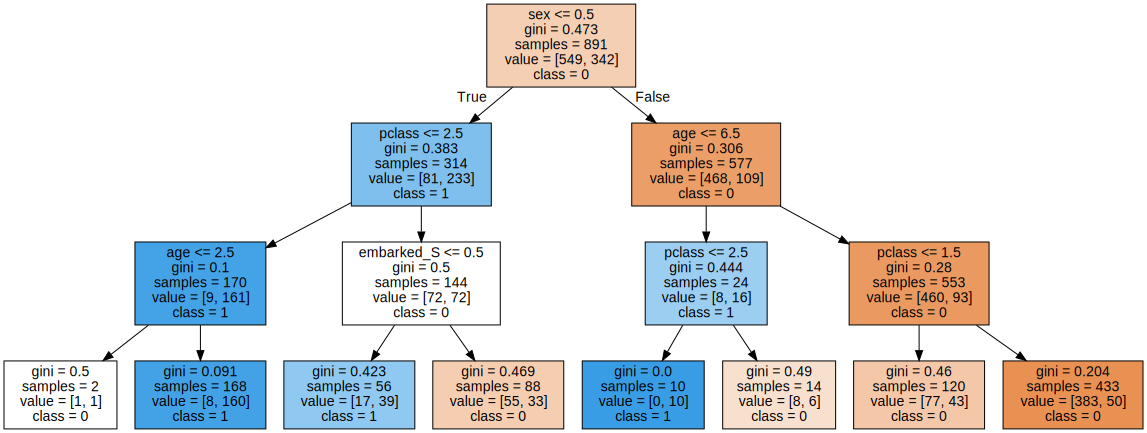

In [15]:
# # create a Graphviz file
# with open("titanic.dot", 'wb') as f:
#     f = export_graphviz(treeclf, out_file=f, feature_names=feature_cols)

graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1'], filled = True))
display(SVG(graph.pipe(format='svg')))


Notice the split in the bottom right, which was made only to increase node purity.

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [16]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,pclass,0.242664
1,sex,0.655584
2,age,0.064494
3,embarked_Q,0.000000
4,embarked_S,0.037258


## Wrapping up decision trees

Here are some advantages and disadvantages of decision trees that we haven't yet talked about:

**Advantages:**

- Can be specified as a series of rules, and are thought to more closely approximate human decision-making than other models
- Non-parametric (will do better than linear regression if relationship between predictors and response is highly non-linear)

<img src="15_linear_vs_tree.png">

**Disadvantages:**

- Small variations in the data can result in a completely different tree
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Can create biased trees if the classes are highly imbalanced (remember that the Gini score depends on balance of classes)

Note that there is not just one decision tree algorithm; instead, there are many variations. A few common decision tree algorithms that are often referred to by name are C4.5, C5.0, and CART. (More details are available in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart).) scikit-learn uses an "optimized version" of CART.

## Resources

- scikit-learn documentation: [Decision Trees](http://scikit-learn.org/stable/modules/tree.html)